In [1]:
#!/big/venv/cuda/bin/python
from langchain_gigachat.chat_models import GigaChat
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, trim_messages
from langgraph.prebuilt import create_react_agent
import speech_recognition as sr
from gtts import gTTS
import os
import configparser
from time import sleep
from glob import glob
import re



# Модель

In [2]:
# читаем конфиг
config = configparser.ConfigParser()
config.read('config.ini')
API_KEY=config.get('gigachat', 'authkey')

# модель
model = GigaChat(
    credentials=API_KEY,
    verify_ssl_certs=False,
)

trimmer = trim_messages(
    max_tokens=800,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)



## Читаем вакансию и генерируем списки вопросов

In [3]:
import psycopg2
def get_connection():
    conn = psycopg2.connect(
        dbname="hrdb",
        user="hruser",
        password="hrpassword",
        host="localhost",
        port="5432"
    )
    return conn
    
def query_db(query):
    con = get_connection()
    cur = con.cursor()
    cur.execute(query)
    res= cur.fetchall()
    con.close()
    return res
    
def exec_db(*query):
    con = get_connection()
    cur = con.cursor()
    cur.execute(*query)
    con.commit()
    con.close()

### Подготовка списка вопросов

In [4]:
def generate_base_question_list(resume):
    bq = open('base_questions.txt').read()
    
    promt=f'''
    резюме: {resume}
    '''
    
    bq=f'''Сформулиуй краткий список вопросов кандидату по: 
    {bq}
    Ответ не должен включать пояснения и дополнительную информацию
    '''
    res = model.invoke([SystemMessage(promt), HumanMessage(bq)])
    questions = res.content.replace('- ','').split('\n')
    return questions

def generate_redflag_question_list():
    bq = open('redflags.txt').read()
    promt=f'''
    резюме: {resume}
    '''
    bq=f'''Сформулиуй краткий список вопросов кандидату по: 
    {bq}
    Список вопросов не должен включать пояснения и дополнительную информацию. 
    Каждый вопрос должен быть в отдельной строке.
    '''
    res = model.invoke([SystemMessage(promt), HumanMessage(bq)])
    questions = res.content.replace('- ','').split('\n')
    return questions

def filter_redflag_question_list(questions, resume):
    promt=f'''
    резюме: {resume}
    '''
    res = model.invoke([SystemMessage(promt), HumanMessage('Напиши кратко пол кандидата мужчина или женщина?')])
    promt=f'''
    список вопросов: {questions}
    '''
    bq=f'''Убери из списка  вопросы освещенные в резюме. 
    Вопросы о беременности и детях надо задавать только кандидату-женщине. Учитывай что кандидат не {res.content}.
    Каждый вопрос должен быть в отдельной строке.
    Список вопросов не должен включать пояснения и дополнительную информацию.
    '''
    res = model.invoke([SystemMessage(promt), HumanMessage(bq)])
    questions = res.content.replace('- ','').split('\n')
    return questions
    
    

def generate_skills_question_list(vacancy):
    promt=f'''
    вакансия: {vacancy}
    '''
    bq=f'''Сформулиуй краткий список вопросов по списку требований кандидату согласно вакансии
    
    Список вопросов не должен включать пояснения и дополнительную информацию. 
    '''
    res = model.invoke([SystemMessage(promt), HumanMessage(bq)])
    questions = res.content.replace('- ','').split('\n')
    return questions

def filter_skills_question_list(question_list, resume):
    promt=f'''
    резюме: {resume}

    список вопросов: {question_list}
    '''
    bq=f'''Убери вопросы освещенные в резюме. Список вопросов не должен включать пояснения и дополнительную информацию. 
    '''
    res = model.invoke([SystemMessage(promt), HumanMessage(bq)])
    questions = res.content.replace('- ','').split('\n')
    return questions





## Настройка workflow графа

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import datetime
import psycopg2
import sqlalchemy as sa
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [28]:


### User
def input_from_user():
    #txt = input()
    wait_for_input=0
    while True:
        print('check', f'select message from interviews where uuid=\'{_uuid}\' and state=\'send\'')
        res = query_db(f'select message from interviews where uuid=\'{_uuid}\' and state=\'send\'')
        if len(res) == 0:
            sleep(5)
            wait_for_input += 5
            if wait_for_input > 600:
                raise 'Слишком долгое ожидание'
                exec_db(f''' update interviews set state=\'init\' where uuid=%s and state=%s ''',(_uuid,'inited'))
            continue
        i=res[0]
        print('Input from user:', i[0])
        print(f''' update interviews set state=\'done\' where uuid=%s and message=%s ''',(_uuid,i[0]))
        exec_db(f''' update interviews set state=\'done\' where uuid=%s and message=%s ''',(_uuid,i[0]))
        return i[0]
    
def send_to_user(txt):
    print('AI: ', txt)
    exec_db(''' insert into interviews (uuid,message,vacancy,resume,state) 
    values(%s,%s,%s,%s,%s)''',(_uuid,txt,vacancy_id,resume_id,'new'))
    sleep(5)
    
    


# Define the function that calls the model
def call_model(state: State):
    print('call_model:',state)
    trimmed_messages=trimmer.invoke(state['messages'], config=config)
    response = model.invoke(trimmed_messages,config=config)
    return {"messages": response}

# Define the function that calls the model
def plan_interview(state: State):
    #print('plan_interview:',state)
    msgs=[]
    msg=AIMessage("Когда бы Вам было удобно запланировать интервью?")
    msgs.append(msg)
    send_to_user(msg.content)
    answer = input_from_user()
    curdate = datetime.date.today().strftime('%d.%m.%Y')
    res= model.invoke([SystemMessage(f'напиши дату планируемого интервью в формате dd.mm.YYYY. Текущая дата {curdate}'),HumanMessage(answer)])
    send_to_user(f'Планируемая дата: {res.content}')
    msgs.append(res.content)
    return {'messages':msgs}


def ask_base(state: State):
    print('ask_base')
    global base_idx
    if len(base_question_list) <= base_idx:
        send_to_user('Переходим к следующему блоку вопросов.')
        return {'messages':[]}
    q = base_question_list[base_idx]
    send_to_user(q)
    base_idx=base_idx+1
    answer = input_from_user()
    return {'messages':[AIMessage(q),HumanMessage(answer)]}

def ask_redflags(state: State):
    print('ask_redflag')
    global redflag_idx
    if len(redflag_question_list) <= redflag_idx:
        send_to_user('Переходим к следующему блоку вопросов.')
        return {'messages':[]}
    q = redflag_question_list[redflag_idx]
    send_to_user(q)
    redflag_idx=redflag_idx+1
    answer = input_from_user()
    return {'messages':[AIMessage(q),HumanMessage(answer)]}

def ask_skills(state: State):
    print('ask_skills')
    global skill_idx
    if len(skill_question_list) <= skill_idx:
        send_to_user('Переходим к следующему блоку вопросов.')
        return {'messages':[]}
    q = skill_question_list[skill_idx]
    send_to_user(q)
    skill_idx=skill_idx+1
    answer = input_from_user()
    return {'messages':[AIMessage(q),HumanMessage(answer)]}




def ask_base_details(state: State):
    print('ask_base_details')
    r = model.invoke(state['messages']+[
        HumanMessage('Сформулируй уточняющий вопрос так чтобы ответ на предыдущий вопрос стал полным')],config=config)
    send_to_user(r.content)
    answer = input_from_user()
    return {'messages':[r.content,HumanMessage(answer)]}

    
def greeting(state: State):
    print('greeting')
    response = model.invoke([
        SystemMessage(f'резюме: {resume}'), 
        HumanMessage('Поздоровайся. Скажи что ты помощник с искусственным интелектом. Ты будешь проводить предварительное собеседование. Скажи Здравствуйте и имя отчество кандидата.')
    ],config=config)
    send_to_user(response.content)
    return {'messages':[SystemMessage(f'резюме: {resume}'), 
response,]}

def goodbye(state: State):
    send_to_user('Всего доброго. Мы с Вами свяжемся')
    return {'messages':[]}
    
def ready_for_interview(state: State):
    print('ready_to_interview')
    response = model.invoke([
        SystemMessage(f'резюме: {resume}'), 
        HumanMessage('Спроси готов ли кандидат пройти собеседование сейчас')
    ],config=config)
    send_to_user(response.content)
    answer = input_from_user()
    print(answer)
    return {'messages':[response,HumanMessage(answer)]}

#answer = input_from_user()
    #return {'messages':[response, HumanMessage(answer)]}
    

In [29]:
def check_ready_to_interview(state: State):
    print('check_ready_to_interview', state['messages'][-1].content)
    response = model.invoke([
        SystemMessage('Ответ положительный. Напиши да или нет.'), 
        state['messages'][-1]], config=config)
    if 'нет'  in response.content.lower():
        print('not ready')
        return False
    else:
        return True

In [30]:
analyze_promt = '''
Проанализируй ответ на вопрос. Ответ общий и уклончивый и требует уточнений или ответ законченный и конкретный.
Напиши без дополнительных объястнений одно из двух: "Да, требует уточнений" или "Нет, ответ законченный"
'''

In [31]:
def check_base_answer(state: State):
    print('check_base_answer')
    answers[base_question_list[base_idx-1]]+='\n'+state['messages'][-1].content
    
    if base_idx >= len(base_question_list):
        return 'next_section'
    r = model.invoke(state['messages']+[HumanMessage(analyze_promt),])
    print('Анализ ответа:', r.content)
    if 'ответ законченный' in r.content.lower():
        return 'next_question'
    else:
        return 'details'

def check_redflag_answer(state: State):
    print('check_redflag_answer')
    answers[base_question_list[base_idx-1]]+='\n'+state['messages'][-1].content
    if redflag_idx >= len(redflag_question_list):
        return 'next_section'

    r = model.invoke(state['messages']+[HumanMessage(analyze_promt),])
    print('Анализ ответа:', r.content)
    if 'требует уточнений' in r.content.lower():
        return 'details'
    else:
        return 'next_question'
    

def check_skills_answer(state: State):
    if skill_idx >= len(skill_question_list):
        return 'next_section'
    r = model.invoke(state['messages']+[HumanMessage(analyze_promt),])
    print('Анализ ответа:', r.content)
    if 'требует уточнений' in r.content.lower():
        return 'details'
    else:
        return 'next_question'
    



In [32]:
memory = MemorySaver()

# Define a new graph
workflow = StateGraph(state_schema=State)

# Define the (single) node in the graph
workflow.add_edge(START, "greeting")
workflow.add_edge('greeting', 'ready_for_interview')
workflow.add_conditional_edges('ready_for_interview', check_ready_to_interview, { True: 'ask_base', False: 'plan_interview'})
workflow.add_edge('plan_interview', 'goodbye')

workflow.add_conditional_edges('ask_base', check_base_answer, 
                               { 
                                   'details': 'ask_addition_base', 
                                   'next_question': 'ask_base', 
                                   'next_section':'ask_redflags'
                               })
workflow.add_conditional_edges('ask_redflags', check_redflag_answer, 
                               { 
                                   'details': 'ask_addition_redflags', 
                                   'next_question': 'ask_redflags', 
                                   'next_section':'ask_skills'
                               })
workflow.add_conditional_edges('ask_skills', check_skills_answer, 
                               { 
                                   'details': 'ask_addition_skills', 
                                   'next_question': 'ask_skills', 
                                   'next_section':'goodbye'
                               })
workflow.add_edge('goodbye', END)

workflow.add_edge('ask_addition_base', 'ask_base')
workflow.add_edge('ask_addition_redflags', 'ask_redflags')
workflow.add_edge('ask_addition_skills', 'ask_skills')


workflow.add_node("greeting", greeting)
workflow.add_node("ready_for_interview", ready_for_interview)
workflow.add_node("plan_interview", plan_interview)
workflow.add_node("ask_base", ask_base)
workflow.add_node("ask_addition_base", ask_base_details)
workflow.add_node("ask_addition_redflags", ask_base_details)
workflow.add_node("ask_addition_skills", ask_base_details)
workflow.add_node("ask_redflags", ask_redflags)
workflow.add_node("ask_skills", ask_skills)
workflow.add_node("goodbye", goodbye)

app = workflow.compile(checkpointer=memory)

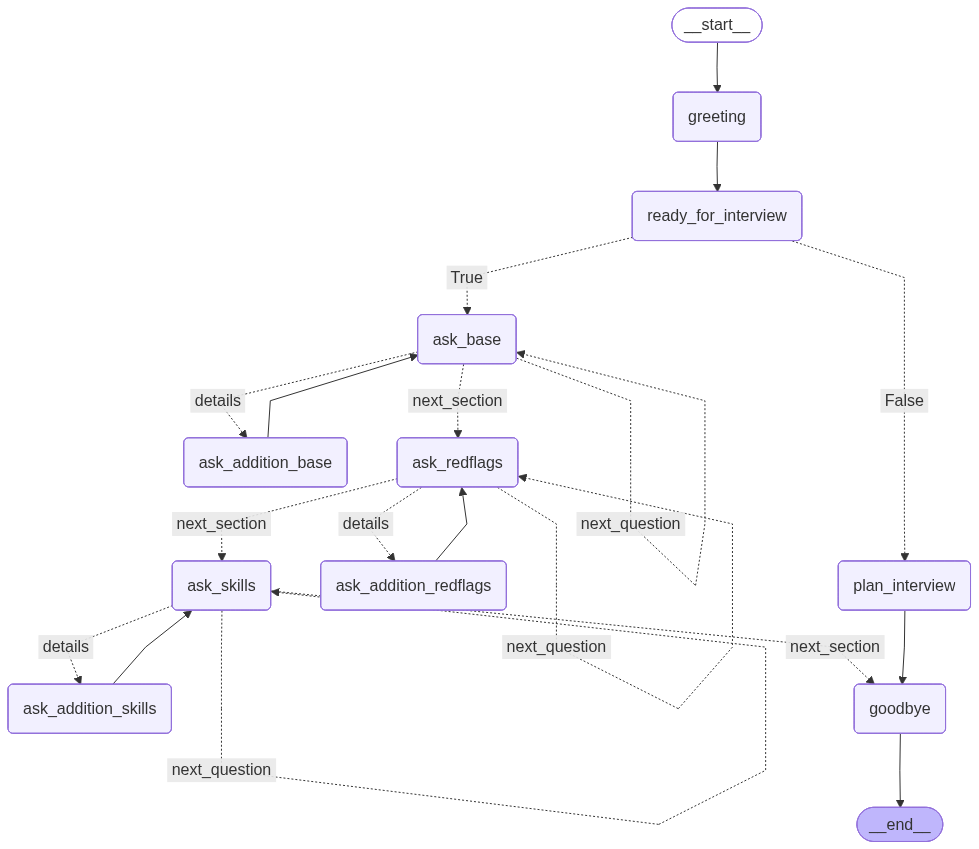

In [33]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)
    pass

In [34]:
base_idx = 0
redflag_idx = 0
skill_idx=0
answer={}

In [35]:
def stream_graph_updates(user_input = ''):
    for event in app.stream({"messages": []}, config=config):
        pass


    

In [ ]:

# инициализация списка вопросов
base_question_list=[]
redflag_question_list=[]
skill_question_list=[]
base_idx = 0
redflag_idx = 0
skill_idx=0
config = {"configurable": {"thread_id": "abc123"}}
while True:
    for row in query_db('''
    with t1 as (
    select uuid,message,"date" as dt,vacancy, resume,state from interviews i where state='init'
    )
    select uuid,message,dt,v.id,r.id,v.vacancy_text ,r.resume_text,state from t1
    join vacancies v on t1.vacancy = v.id 
    join resume r  on t1.resume  = r.id 
    order by dt asc
    '''):
        #print(i)
        _uuid = row[0]
        vacancy_id = row[3]
        resume_id = row[4]
        vacancy = row[5]
        resume = row[6]
        print(f'vacancy - resume {vacancy_id} - {resume_id}')
        exec_db('''update interviews set state='inited' where uuid=%s and state=%s''',(_uuid,'init'))
        config = {"configurable": {"thread_id": _uuid}}
    
        # подготовка вопросов
        base_question_list = generate_base_question_list(resume)
        redflag_question_list = generate_redflag_question_list()
        skill_question_list = generate_skills_question_list(vacancy)
    
        # фильтруем под конкретного кандидата
        redflag_question_list = filter_redflag_question_list('\n'.join(redflag_question_list),resume)
        
        skill_question_list = filter_skills_question_list('\n'.join(skill_question_list), resume)
        
        
        base_question_list=[re.sub('\<\S+\>','',s) for s in base_question_list]
        redflag_question_list=[re.sub('\<\S+\>','',s) for s in redflag_question_list]
        skill_question_list=[re.sub('\<\S+\>','',s) for s in skill_question_list]
    
        base_idx = 0
        redflag_idx = 0
        skill_idx=0
        print('start agent\n\n')
        try:
            stream_graph_updates()
        except:
            pass
    sleep(5)

vacancy - resume 2 - 1
start agent


greeting
AI:  Здравствуйте, Евгений Дмитриевич! Рад знакомству. Я — ИИ-помощник, который поможет провести предварительное собеседование. Давайте начнём нашу беседу!
ready_to_interview
AI:  «Вы готовы к тому, чтобы пройти собеседование прямо сегодня?»
check select message from interviews where uuid='94062b93-fee9-410c-849b-1d0b1d0a166d' and state='send'
check select message from interviews where uuid='94062b93-fee9-410c-849b-1d0b1d0a166d' and state='send'
check select message from interviews where uuid='94062b93-fee9-410c-849b-1d0b1d0a166d' and state='send'
check select message from interviews where uuid='94062b93-fee9-410c-849b-1d0b1d0a166d' and state='send'
check select message from interviews where uuid='94062b93-fee9-410c-849b-1d0b1d0a166d' and state='send'
check select message from interviews where uuid='94062b93-fee9-410c-849b-1d0b1d0a166d' and state='send'
check select message from interviews where uuid='94062b93-fee9-410c-849b-1d0b1d0a166d' a